# WaffleHacks 2022 - Computational Imaging Workshop - Light Fields
#### Instructed by Kevin Gauld


## Focal Depths -- Pinhole vs Lens

<div>
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987864862644400148/unknown.png" width="800">
</div>

## Focal Stacks


<div>
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987865301230161920/unknown.png" width="500">
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987865625818955856/unknown.png" width="1000">
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987866194696630302/unknown.png" width="1000">
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987867583082561546/unknown.png" width="1000">
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987867884090982410/unknown.png" width="1000">
</div>


## Plenoptic Imaging


<div>
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987868233765883944/unknown.png" width="500">
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987868422664749056/unknown.png" width="500">
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987868585001107536/unknown.png" width="500">
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987870957685313566/unknown.png" width="500">
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987871093920509952/unknown.png" width="1000">
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987873194738339920/unknown.png" width="1000">

</div>

In [90]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage as ndimage
import math

In [91]:
lightfield = cv2.imread('light-field.png')[:,:,::-1]/255.0

In [111]:
def norm_img(img) -> np.ndarray:
    '''
    Normalize a given image (scale from [min, max] to [0,1])
    '''
    return (img - np.min(img))/np.ptp(img)

def grayscale(img) -> np.ndarray:
    '''
    Convert an image to grayscale
    '''
    return 0.3*img[:,:,0] + 0.6*img[:,:,1] + 0.1*img[:,:,2]

def show_image(img, ticks=False):
    '''
    Display an image with or without axis ticks, and rescale if necessary
    '''
    if not ticks:
        plt.xticks([])
        plt.yticks([])
    
    imtoshow = img
    if np.min(img) < 0 or np.max(img) > 1:
        imtoshow = norm_img(img)
    plt.imshow(imtoshow)
    
def show_focal_stack(focalstack, depths, ticks=False):
    '''
    Display all images in a focal stack
    '''
    rows = math.ceil(len(focalstack)/5.0)
    plt.figure(figsize=(15, 3*rows))
    
    for i in range(len(focalstack)):
        plt.subplot(rows,5,i+1)
        show_image(focalstack[i])
        plt.xlabel('depth: ' + str(depths[i]))

# Light Field

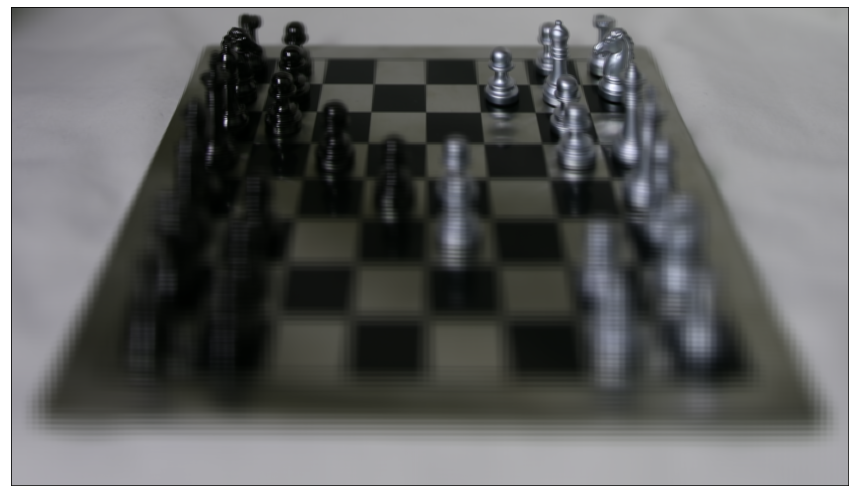

In [52]:
plt.figure(figsize=(15,15))
show_image(lightfield)

# Show Sub-Aperture Views

In [44]:
def load_light_field(lightfield, stride=16):
    field = []
    
    for u in range(stride):
        field.append([])
        for v in range(stride):
            field[u].append(lightfield[u::stride, v::stride])
    
    return np.array(field)

In [45]:
field = load_light_field(lightfield)
sub_aps = np.hstack(np.hstack(field))
cv2.imwrite('sub-apertures.png', sub_aps*255)

True

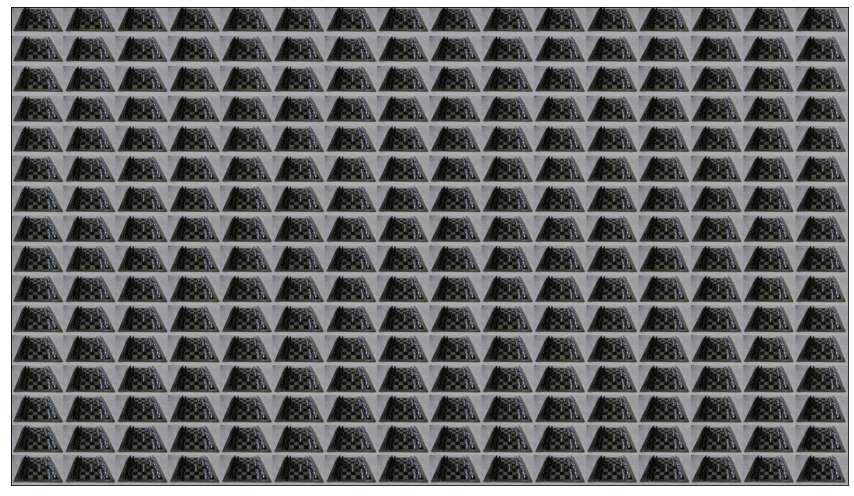

In [48]:
plt.figure(figsize=(15,15))
show_image(sub_aps)

## Individual sub-apertures

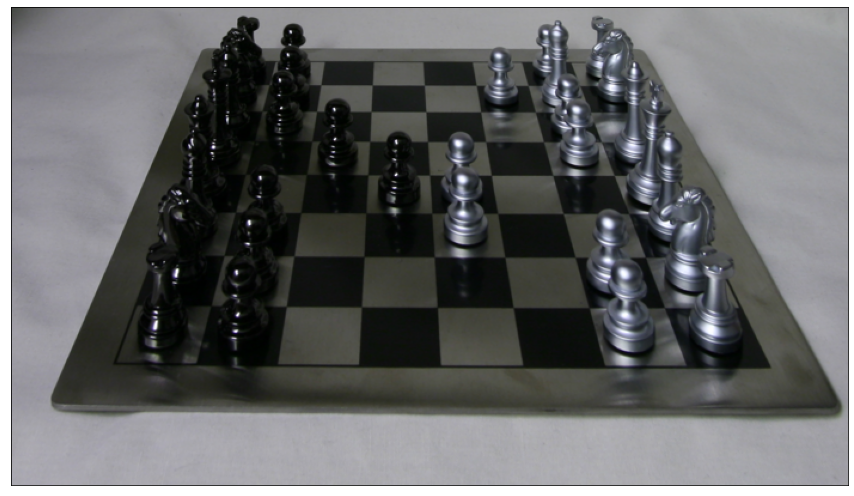

In [49]:
plt.figure(figsize=(15,15))
show_image(field[0][0])

# Refocusing - Building a focal stack

In [71]:
def focus_to_depth(field, depth):
    s_uv = field.shape[:2]
    s_img = field.shape[2:]
    stack = np.zeros(s_img)
    
    for u in range(s_uv[0]):
        for v in range(s_uv[1]):
            shift = (depth * (u - s_uv[0]//2), depth * (s_uv[1]//2 - v), 0)
            stack += ndimage.shift(field[u,v], shift, order=0)
    
    return stack / (s_uv[0]*s_uv[1])

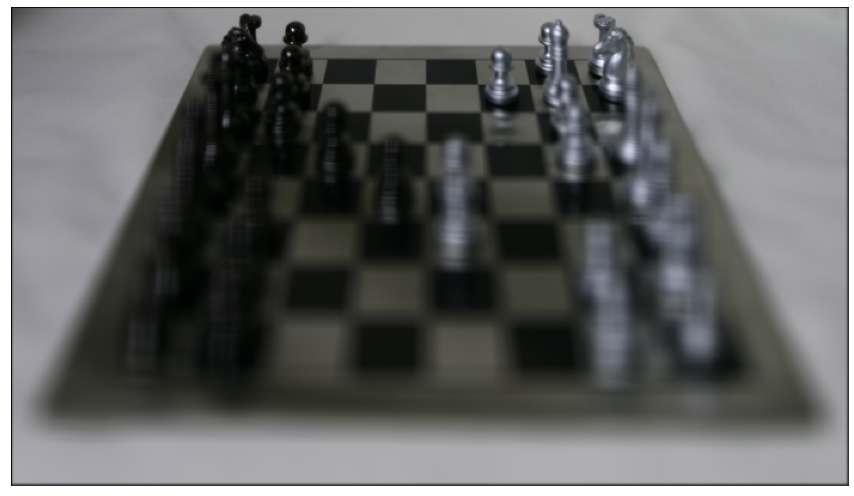

In [72]:
fs = focus_to_depth(field, 0.2)
plt.figure(figsize=(15,15))
show_image(fs)

In [81]:
def build_focal_stack(field, depths):
    focalstack = []
    for d in depths:
        fs = focus_to_depth(field, d)
        focalstack.append(fs)
        print('Added depth:', d)
    return focalstack

In [100]:
depths = np.linspace(-2, 1, 11)
depths = np.around(depths, decimals=1)
focalstack = build_focal_stack(field, depths)

Added depth: -2.0
Added depth: -1.7
Added depth: -1.4
Added depth: -1.1
Added depth: -0.8
Added depth: -0.5
Added depth: -0.2
Added depth: 0.1
Added depth: 0.4
Added depth: 0.7
Added depth: 1.0


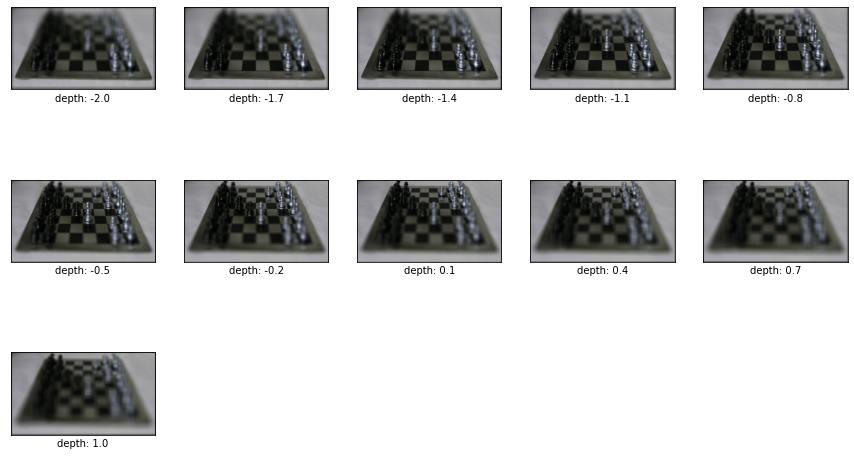

In [103]:
show_focal_stack(focalstack, depths)

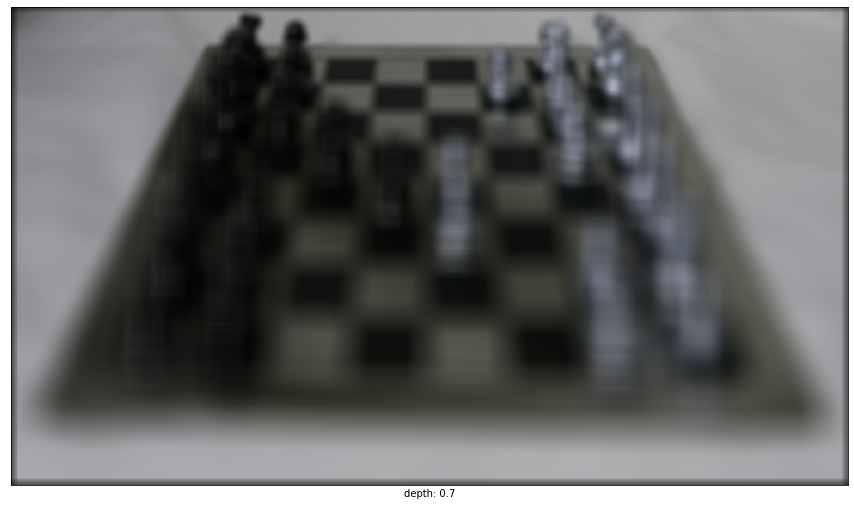

In [126]:
plt.figure(figsize=(15,15))
k = 9
show_image(focalstack[k])
plt.xlabel('depth: '+ str(depths[k]));

# Refocusing - Creating an All-In-Focus Image

In [112]:
def refocus(focalstack, sig1, sig2):
    gray_stack = np.array([grayscale(img) for img in focalstack])
    stack_hf = gray_stack - ndimage.filters.gaussian_filter(gray_stack, (0,sig1,sig1))
    w = ndimage.filters.gaussian_filter(stack_hf**2, (0,sig2,sig2))[..., None]
    return (w*focalstack).sum(axis=0) / w.sum(axis=0)

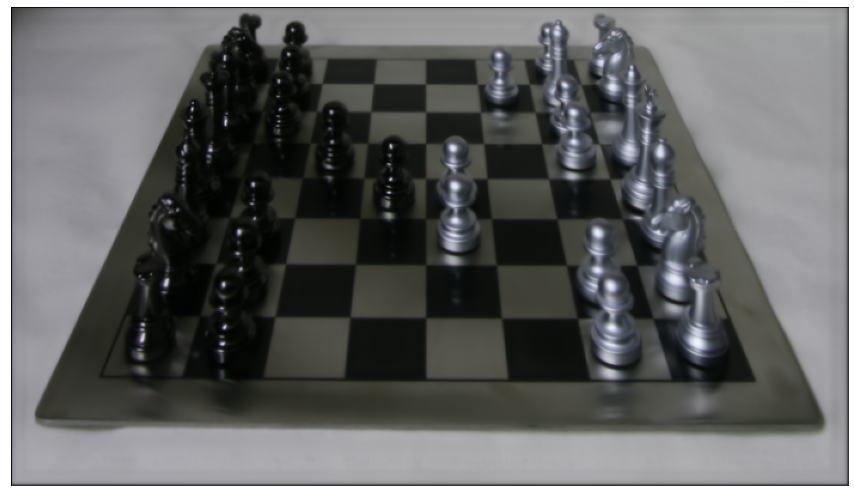

In [114]:
allinfocus = refocus(focalstack, 2, 3)
plt.figure(figsize=(15,15))
show_image(allinfocus)

# Depth map from all in focus image

In [115]:
def depth(focalstack, sig1, sig2):
    gray_stack = np.array([grayscale(img) for img in focalstack])
    stack_hf = gray_stack - ndimage.filters.gaussian_filter(gray_stack, (0,sig1,sig1))
    depth_colors = np.linspace(0, 1, 11)[:, None, None, None] * [1, 1, 1]
    w = ndimage.filters.gaussian_filter(stack_hf**2, (0,sig2,sig2))[..., None]
    return (w*depth_colors).sum(axis=0) / w.sum(axis=0)

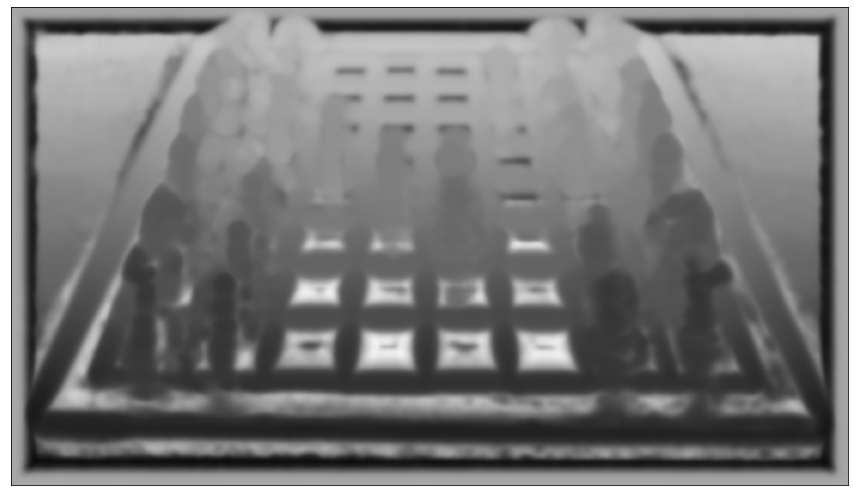

In [122]:
depthimg = depth(focalstack, 2, 3)
plt.figure(figsize=(15,15))
show_image(depthimg)

In [127]:
depthimg.shape

(400, 700, 3)